# Downloading and Unzipping Data

In [ ]:
 !wget https://github.com/mralisoltani/CNN_Tumor/raw/main/Tumor.zip
 !unzip -q /content/Tumor.zip


--2021-12-02 12:01:47--  https://github.com/mralisoltani/CNN_Tumor/raw/main/Tumor.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mralisoltani/CNN_Tumor/main/Tumor.zip [following]
--2021-12-02 12:01:47--  https://raw.githubusercontent.com/mralisoltani/CNN_Tumor/main/Tumor.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14338568 (14M) [application/zip]
Saving to: ‘Tumor.zip’

Tumor.zip           100%[===================>]  13.67M  --.-KB/s    in 0.1s    

2021-12-02 12:01:48 (119 MB/s) - ‘Tumor.zip’ saved [14338568/14338568]



# Importing Packages

In [ ]:
import torch
from torch import nn 
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset,random_split
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Loading Data

In [ ]:
n = 3762
image=[]
cw = os.getcwd().replace(os.sep, '/')
trans = transforms.Compose([transforms.ToTensor()])
for i in range(n):
    image.append(np.array(Image.open(cw + "/Brain_Tumor/Image" + str(i+1) + ".jpg").resize((48,48))))

temp = pd.read_csv(cw + "/Brain_Tumor.csv",index_col=None, header=None).to_numpy()
temp = temp[1:,1]
targets = np.zeros((n,1),dtype=int)
targets = []
for i in range(n):
    targets.append(int(temp[i]))

data = np.array(image)
data = data/255
data = torch.from_numpy(data).permute((0,3,2,1))
data = data.float()
targets = torch.tensor(targets)
dataset = TensorDataset(data,targets)
batch_size = 4
val_size = int(np.ceil(len(dataset)*0.2))
train_size = len(dataset) - val_size 

train_data,test_data = random_split(dataset,[train_size,val_size])
train_loader = DataLoader(train_data,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size = batch_size,shuffle=True)

# Train Feature and Label Size and Datatype

In [ ]:
for batch in train_loader:
    print(f"Features' size is: {batch[0][0].shape}")
    print(f"Features' type is: {batch[0][0].dtype}")
    print(f"Lable type is: {batch[1][0].dtype}")
    break

Features' size is: torch.Size([3, 48, 48])
Features' type is: torch.float32
Lable type is: torch.int64


# Showing One Batch of Data

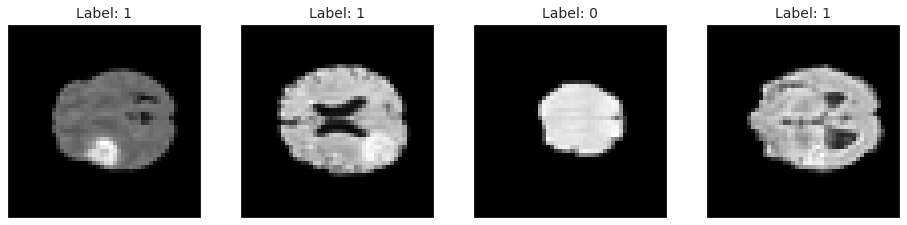

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    for idx in range(len(images)):
        ax[idx].imshow(images[idx][0], cmap='gray')
        ax[idx].grid(False)
        ax[idx].axes.xaxis.set_visible(False)
        ax[idx].axes.yaxis.set_visible(False)
        ax[idx].set_title(f"Label: {labels[idx]}", fontsize=14)
    break

# Fully Connected

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

#Define model
class FullyConnectedNN(nn.Module):
    def __init__(self):
        super(FullyConnectedNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*48*48, 512),
            nn.ReLU(),
            nn.Linear(512, 24),
            nn.ReLU(),
            nn.Linear(24, 2)
        )
    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out
fc_nn = FullyConnectedNN().to(device)

Using cuda device


# Show Model Summary

In [ ]:
print(fc_nn)

FullyConnectedNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6912, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=2, bias=True)
  )
)


# Loss Function and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fc_nn.parameters(), lr=1e-3)

# Train Function

In [ ]:
def train(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # Computer prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss and batch 
        if batch%100 == 0:
            l, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {l:>7f}   [{current:>5d}/{size:<5d}]")

# Test Function

In [ ]:
def test(data_loader, model, loss_fn):
    size = len(data_loader.dataset)
    no_batches = len(data_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(axis=1)==y).type(torch.float).sum().item()
    test_loss /= no_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {100*correct:>0.1f}%, Avg loss: {test_loss:>7f}\n")
    return 100*correct, test_loss

# Train the model

Epoch 1
----------------------------------------
loss: 0.669542   [    4/3009 ]
loss: 0.681561   [  404/3009 ]
loss: 0.692020   [  804/3009 ]
loss: 0.666111   [ 1204/3009 ]
loss: 0.653098   [ 1604/3009 ]
loss: 0.678209   [ 2004/3009 ]
loss: 0.663186   [ 2404/3009 ]
loss: 0.625253   [ 2804/3009 ]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.628525

Epoch 2
----------------------------------------
loss: 0.612839   [    4/3009 ]
loss: 0.522712   [  404/3009 ]
loss: 0.560244   [  804/3009 ]
loss: 0.570227   [ 1204/3009 ]
loss: 0.585578   [ 1604/3009 ]
loss: 0.984569   [ 2004/3009 ]
loss: 0.509876   [ 2404/3009 ]
loss: 0.504762   [ 2804/3009 ]
Test Error: 
 Accuracy: 73.4%, Avg loss: 0.548748

Epoch 3
----------------------------------------
loss: 0.332286   [    4/3009 ]
loss: 0.555680   [  404/3009 ]
loss: 0.565182   [  804/3009 ]
loss: 0.605928   [ 1204/3009 ]
loss: 0.306960   [ 1604/3009 ]
loss: 0.845349   [ 2004/3009 ]
loss: 0.162499   [ 2404/3009 ]
loss: 0.622162   [ 2804/3009 ]
Test Er

Text(0, 0.5, 'Loss')

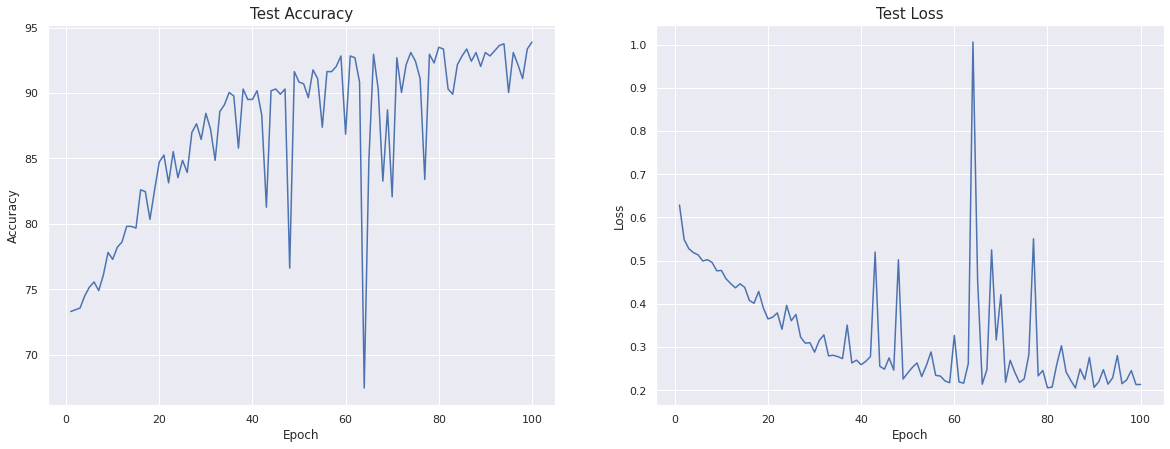

In [ ]:
test_stats = {'accuracies':[], 'losses':[]}
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n{'-'*40}")
    train(train_loader, fc_nn, loss_fn, optimizer)
    test_acc, test_l = test(test_loader, fc_nn, loss_fn)
    test_stats['accuracies'].append(test_acc)
    test_stats['losses'].append(test_l)
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(range(1, epochs+1), test_stats['accuracies'])
ax[0].set_title("Test Accuracy", fontsize=15)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1, epochs+1), test_stats['losses'])
ax[1].set_title("Test Loss", fontsize=15)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

# Convolutional Neural Network

In [ ]:
class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv_net = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(24*24*64, 512),
        nn.ReLU(),
        nn.Linear(512, 24),
        nn.ReLU(),
        nn.Linear(24, 2)
        )
    def forward(self, x):
        return self.conv_net(x)
conv_nn = cnn().to(device)

# Show Conv Net

In [ ]:
print(conv_nn)

cnn(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=36864, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=24, bias=True)
    (9): ReLU()
    (10): Linear(in_features=24, out_features=2, bias=True)
  )
)


Epoch 1
----------------------------------------
loss: 0.708023   [    4/3009 ]
loss: 0.620196   [  404/3009 ]
loss: 0.625529   [  804/3009 ]
loss: 0.625299   [ 1204/3009 ]
loss: 0.620992   [ 1604/3009 ]
loss: 0.693224   [ 2004/3009 ]
loss: 0.624843   [ 2404/3009 ]
loss: 0.642399   [ 2804/3009 ]
Test Error: 
 Accuracy: 55.2%, Avg loss: 0.677077

Epoch 2
----------------------------------------
loss: 0.683348   [    4/3009 ]
loss: 0.571274   [  404/3009 ]
loss: 0.747167   [  804/3009 ]
loss: 0.742030   [ 1204/3009 ]
loss: 0.712273   [ 1604/3009 ]
loss: 0.552634   [ 2004/3009 ]
loss: 0.633722   [ 2404/3009 ]
loss: 0.694997   [ 2804/3009 ]
Test Error: 
 Accuracy: 55.4%, Avg loss: 0.650119

Epoch 3
----------------------------------------
loss: 0.669172   [    4/3009 ]
loss: 0.599439   [  404/3009 ]
loss: 0.573169   [  804/3009 ]
loss: 0.649828   [ 1204/3009 ]
loss: 0.660684   [ 1604/3009 ]
loss: 0.563075   [ 2004/3009 ]
loss: 0.768559   [ 2404/3009 ]
loss: 0.527344   [ 2804/3009 ]
Test Er

Text(0, 0.5, 'Loss')

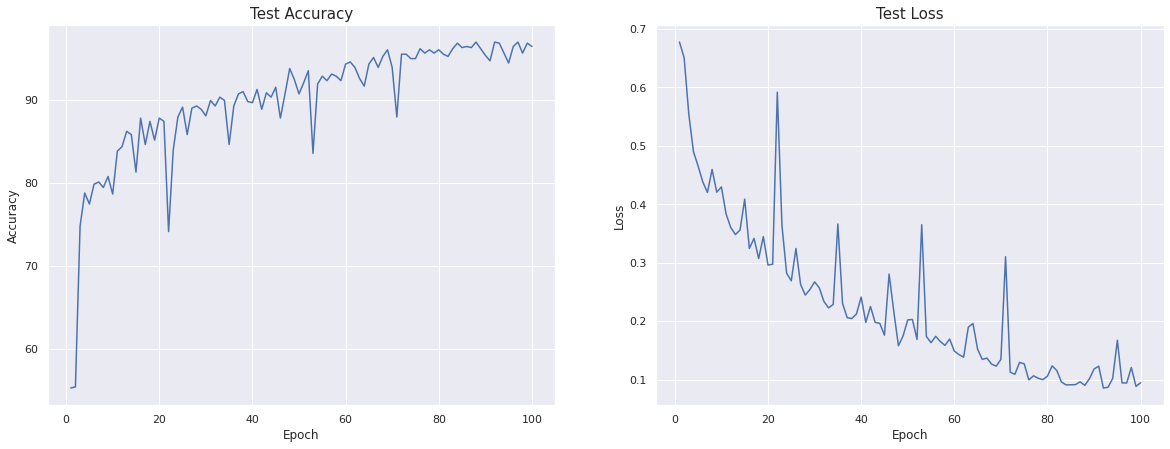

In [ ]:
optimizer = torch.optim.SGD(conv_nn.parameters(), lr=1e-3)
conv_test_stats = {'accuracies':[], 'losses':[]}
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n{'-'*40}")
    train(train_loader, conv_nn, loss_fn, optimizer)
    test_acc, test_l = test(test_loader, conv_nn, loss_fn)
    conv_test_stats['accuracies'].append(test_acc)
    conv_test_stats['losses'].append(test_l)
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(range(1, epochs+1), conv_test_stats['accuracies'])
ax[0].set_title("Test Accuracy", fontsize=15)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[1].plot(range(1, epochs+1), conv_test_stats['losses'])
ax[1].set_title("Test Loss", fontsize=15)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")

<div style="direction:rtl"> نمودار مدل کانولوشنی نموداری نرم‌تر است نسبت به نمودار مدل تمام متصل که پرش‌هایی در آن دیده‌می‌شود. این اتفاق احتمالا به دلیل این است که پارامتر‌ها در مدل کانولوشنی با یکدیگر به اشتراک گذاشته می‌شوند و همینطور مدل کانولوشنی بخش‌هایی از تصویر را می‌بیند و اطلاعاتی مکانی را تا حدی متوجه می‌شود ولی مدل تمام متصل این اطلاعات رو از دست می‌دهد. </div>


# References
- https://pytorch.org/tutorials/